In [1]:
#@title <font size="5"> ឵឵Install Required Libraries</font> {vertical-output: true}
from IPython.display import clear_output

import os
os.system('pip install bing-image-downloader')
os.system('pip install face_recognition')

import numpy as np
import pickle
import cv2
from google.colab.patches import cv2_imshow

import imutils
from imutils import build_montages
from imutils import paths
from imutils.video import VideoStream

from bing_image_downloader import downloader
from requests import exceptions
from google.colab import drive
from sklearn.cluster import DBSCAN
import face_recognition
import time

clear_output()
print('Installation finished.')

Installation finished.


In [2]:
#@title <font size="5"> ឵឵ Mount your GDrive</font> {vertical-output: true}

drive.mount('/content/drive')

clear_output()
print('Drive mounted.')

Drive mounted.


In [ ]:
#@title Select Source of Pictures {vertical-output: true}

#text = 'value' #@param {type:"string"}
Choices = 'Online images' #@param ["Online images", "Personal GDrive images"]


#print(text)
print('Selected Choice: ', Choices)
#print(text_and_dropdown)

In [4]:
#@title Enter the address of the GDrive folder containing the images <font size="2"> (If the personal photos option was selected)</font> {vertical-output: true}

bool_personal = False
Address = '' #@param {type:"string"}
#Choices = 'Personal GDrive images' #@param ["Online images", "Personal GDrive images"]
# Names_lower = Names.lower().replace(' ', '_')
# var_list = Names_lower.split(",")
# #print(Names)
# my_list = Names.split(",")
drive_path = '/content/drive'
final_address = os.path.join(drive_path,Address)
if (len(Address)>0):
    bool_personal = True
    print('Final Address: ')
    print(final_address)  

In [5]:
#@title Enter names of people <font size="2"> (comma separated) </font> {vertical-output: true}

Names = 'Michael Corleone,Vito Corleone(Marlon Brando),Kay Adams-Corleone,Tom Hagen' #@param {type:"string"}
#Choices = 'Personal GDrive images' #@param ["Online images", "Personal GDrive images"]
Names_lower = Names.lower().replace(' ', '_')
var_list = Names_lower.split(",")
#print(Names)
my_list = Names.split(",")
print('Selected: ')
print(my_list, sep = ", ")  

#print(text_and_dropdown)

Selected: 
['Michael Corleone', 'Vito Corleone(Marlon Brando)', 'Kay Adams-Corleone', 'Tom Hagen']


In [6]:
#@title ← Enter output directory for downloading images {vertical-output: true}

Directory = 'Output_Folder' #@param {type:"string"}
#Choices = 'Personal GDrive images' #@param ["Online images", "Personal GDrive images"]
# Names_lower = Names.lower().replace(' ', '_')
# var_list = Names_lower.split(",")
#print(Names)
# my_list = Names.split(",")
# user_output = 'datasetv7'
output_directory = os.path.join("drive/MyDrive/",Directory)

print('Final directory: ')
print(output_directory)  

#print(text_and_dropdown)

Final directory: 
drive/MyDrive/Output_Folder


In [7]:
#@title Number of images of each person <font size="2">(30-50 are enough)</font> {vertical-output: true}

Number = "40" #@param {type:"string"}
Number = int(Number)
#Choices = 'Personal GDrive images' #@param ["Online images", "Personal GDrive images"]
# Names_lower = Names.lower().replace(' ', '_')
# var_list = Names_lower.split(",")
#print(Names)
# my_list = Names.split(",")
# user_output = 'datasetv7'
# output_directory = os.path.join("drive/MyDrive/",Directory)

#print('Final directory: ')
print(Number)  

#print(text_and_dropdown)

40


In [8]:
#@title Download the images {vertical-output: true}

categories={}
for i in range(len(my_list)):
    categories[var_list[i]] = my_list[i]
img_paths = {}


for query, name in categories.items():
    # img_paths[name] = download_images(query=query, 
    #                                   output_directory=output_directory,
    #                                   image_directory=name)
    downloader.download(name, limit=Number,  output_dir=output_directory, 
    adult_filter_off=True, force_replace=False, timeout=60)
    #clear_output()
clear_output()
print("Downloaded")

Downloaded


# Face Encodings

In [9]:
#@title Get the face encodings of all the images  {vertical-output: true}

if (bool_personal):
  output_directory =  final_address

imagePaths = list(paths.list_images(os.path.join('/content/',output_directory)))

knownEncodings = []
knownNames = []

for (i, imagePath) in enumerate(imagePaths):
  if (i%20==0):    
      print("[INFO] processing image {}/{}".format(i + 1,
        len(imagePaths)))
  name = imagePath.split(os.path.sep)[-2]
  image = cv2.imread(imagePath)
  if image is None:
      print("[INFO] deleting: {}".format(imagePath))
      os.remove(imagePath)
      continue
  rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  boxes = face_recognition.face_locations(rgb,
    model="hog")
  encodings = face_recognition.face_encodings(rgb, boxes)
  for encoding in encodings:
    knownEncodings.append(encoding)
    knownNames.append(name)
clear_output()
print("Processed all %d images" % (len(imagePaths)))

Processed all 159 images


In [10]:
#@title To serialize the face encodings of all the images {vertical-output: true}
print("[INFO] serializing encodings...")
data = {"encodings": knownEncodings, "names": knownNames}
f = open("encodings.pickle", "wb")
f.write(pickle.dumps(data))
f.close()
clear_output()
print("Serialized the encoding")

Serialized the encoding


# Testing on a photo

In [11]:
#@title ←  Upload test image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
key, value = list(uploaded.items())[0]
filename=key
clear_output()
print("Image loaded")

IndexError: ignored

In [ ]:
#@title ←  Results on test image
#print("[INFO] loading encodings...")
data = pickle.loads(open("/content/encodings.pickle", "rb").read())
# load the input image and convert it from BGR to RGB
image = cv2.imread(os.path.join('/content/',filename))
image = imutils.resize(image, width=500)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# detect the (x, y)-coordinates of the bounding boxes corresponding
# to each face in the input image, then compute the facial embeddings
# for each face
#print("[INFO] recognizing faces...")
boxes = face_recognition.face_locations(rgb,
	model="cnn")
encodings = face_recognition.face_encodings(rgb, boxes)
# initialize the list of names for each face detected
names = []
for encoding in encodings:
	# attempt to match each face in the input image to our known
	# encodings
	matches = face_recognition.compare_faces(data["encodings"],
		encoding)
	name = "Unknown"
  	# check to see if we have found a match
	if True in matches:
		# find the indexes of all matched faces then initialize a
		# dictionary to count the total number of times each face
		# was matched
		matchedIdxs = [i for (i, b) in enumerate(matches) if b]
		counts = {}
		# loop over the matched indexes and maintain a count for
		# each recognized face face
		for i in matchedIdxs:
			name = data["names"][i]
			counts[name] = counts.get(name, 0) + 1
		# determine the recognized face with the largest number of
		# votes (note: in the event of an unlikely tie Python will
		# select first entry in the dictionary)
		name = max(counts, key=counts.get)
	
	# update the list of names
	names.append(name)
for ((top, right, bottom, left), name) in zip(boxes, names):
	# draw the predicted face name on the image
	cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
	y = top - 15 if top - 15 > 15 else top + 15
	cv2.putText(image, name, (left, y), cv2.FONT_HERSHEY_SIMPLEX,
		0.55, (0, 255, 0), 2)
# show the output image
cv2_imshow(image)

# Testing on a video

In [ ]:
#@title ←  Upload test video
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
key, value = list(uploaded.items())[0]
filename=key
clear_output()
print("Video loaded")

In [ ]:
#@title ←  Get face-identified video in output folder
cap = cv2.VideoCapture(os.path.join('/content/',filename))
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
data = pickle.loads(open("/content/encodings.pickle", "rb").read())
# initialize the video stream and pointer to output video file, then
# allow the camera sensor to warm up
vs = VideoStream(src=0).start()
writer = None
time.sleep(2.0)
input=os.path.join('/content/',filename)
#str(output_directory)+'/video_result.mp4'
output = str(output_directory)+'/video_result.mp4'
display_ = 1
video_file=True
vs = cv2.VideoCapture(input)
cur_frame=0

while True:
  
  if video_file:
        (grabbed, frame) = vs.read()
        if not grabbed:
            break
  else:
        frame = vs.read()
  cur_frame+=1
  if (cur_frame%100==0):
      print("Processing %d / %d frame" %(cur_frame,length))

  rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  rgb = imutils.resize(frame, width=750)
  r = frame.shape[1] / float(rgb.shape[1])
  boxes = face_recognition.face_locations(rgb,model="cnn") 
  encodings = face_recognition.face_encodings(rgb, boxes)
  names = []
  for encoding in encodings:

    matches = face_recognition.compare_faces(data["encodings"],encoding)
    name = "Unknown"  
    if True in matches:
        matchedIdxs = [i for (i, b) in enumerate(matches) if b]
        counts = {}

        for i in matchedIdxs:
          name = data["names"][i]
          counts[name] = counts.get(name, 0) + 1
  
        name = max(counts, key=counts.get)

        names.append(name)
  for ((top, right, bottom, left), name) in zip(boxes, names):

        top = int(top * r)
        right = int(right * r)
        bottom = int(bottom * r)
        left = int(left * r)

        cv2.rectangle(frame, (left, top), (right, bottom),
          (0, 255, 0), 2)
        y = top - 15 if top - 15 > 15 else top + 15
        cv2.putText(frame, name, (left, y), cv2.FONT_HERSHEY_SIMPLEX,
          0.75, (0, 255, 0), 2)
  if writer is None and output is not None:
      fourcc = cv2.VideoWriter_fourcc(*"MJPG")
      writer = cv2.VideoWriter(output, fourcc, 20,
        (frame.shape[1], frame.shape[0]), True)
  if writer is not None:
    writer.write(frame)

vs.release()

if writer is not None:
  writer.release()
clear_output()
print('Saved video to: ',end='')
print(str(output_directory)+'/video_result.mp4')

# Clustering and renaming

[INFO] # Unique faces: 4
[INFO] faces for face ID: 0


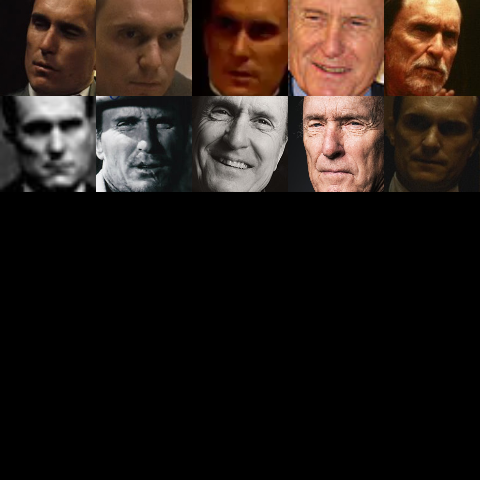

[INFO] faces for face ID: 1


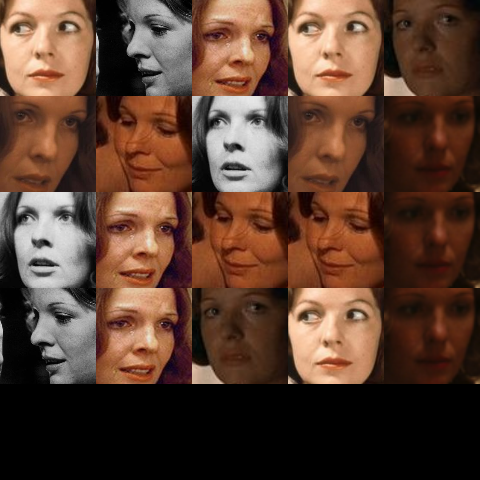

[INFO] faces for face ID: 2


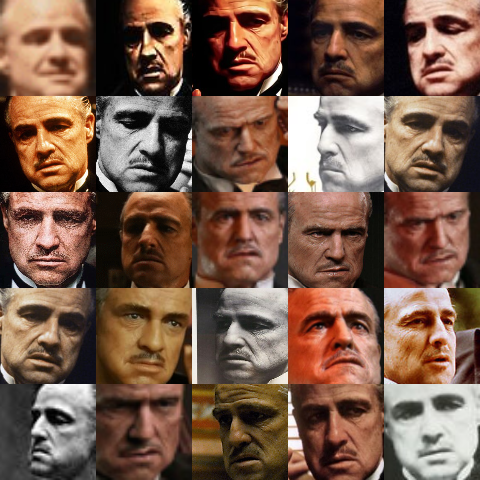

[INFO] faces for face ID: 3


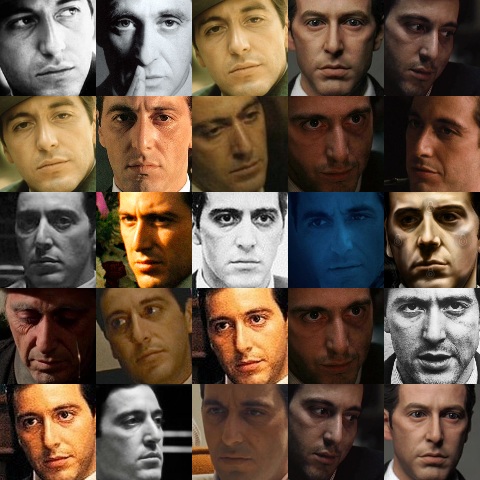

In [12]:
#@title See a montage of similar faces

dataset_cluster = output_directory
#print("[INFO] quantifying faces...")
imagePaths = list(paths.list_images(dataset_cluster))
data = []
imagePaths.reverse()
# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
  # load the input image and convert it from BGR (OpenCV ordering)
  # to RGB (dlib ordering)
  if((i+1)%50==0):
    print("[INFO] processing image {}/{}".format(i + 1,
      len(imagePaths)))
  #print(imagePath)
  image = cv2.imread(imagePath)
  if image is None:
      #print("[INFO] deleting: {}".format(imagePath))
      os.remove(imagePath)
      continue
  else:
      rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      boxes = face_recognition.face_locations(rgb,
        model='hog')
        # compute the facial embedding for the face
      encodings = face_recognition.face_encodings(rgb, boxes)
      d = [{"imagePath": imagePath, "loc": box, "encoding": enc}
        for (box, enc) in zip(boxes, encodings)]
      data.extend(d)
#print("[INFO] serializing encodings...")
f = open('encodings_cluster.pickle', "wb")
f.write(pickle.dumps(data))
f.close()
#print("[INFO] loading encodings...")
data = pickle.loads(open('encodings_cluster.pickle', "rb").read())
data = np.array(data)
encodings = [d["encoding"] for d in data]
#print("[INFO] clustering...")
clt = DBSCAN(metric="euclidean", n_jobs=-1)
clt.fit(encodings)
# determine the total number of unique faces found in the dataset
labelIDs = np.unique(clt.labels_)
numUniqueFaces = len(np.where(labelIDs > -1)[0])
clear_output()
print("[INFO] # Unique faces: {}".format(numUniqueFaces))
for labelID in labelIDs[1:]:
  # find all indexes into the `data` array that belong to the
  # current label ID, then randomly sample a maximum of 25 indexes
  # from the set
  print("[INFO] faces for face ID: {}".format(labelID))
  idxs = np.where(clt.labels_ == labelID)[0]
  idxs = np.random.choice(idxs, size=min(25, len(idxs)),
    replace=False)
  # initialize the list of faces to include in the montage
  faces = []
  for i in idxs:
    # load the input image and extract the face ROI
    #print(data[i]["imagePath"])
    image = cv2.imread(data[i]["imagePath"])
    (top, right, bottom, left) = data[i]["loc"]
    face = image[top:bottom, left:right]
    # force resize the face ROI to 96x96 and then add it to the
    # faces montage list
    face = cv2.resize(face, (96, 96))
    faces.append(face)
  montage = build_montages(faces, (96, 96), (5, 5))[0]
  
  # show the output montage
  title = "Face ID #{}".format(labelID)
  title = "Unknown Faces" if labelID == -1 else title
  cv2_imshow(montage)

In [14]:
#@title ← Enter names of persons by ID <font size="2"> (Serialwise) (comma separated) </font>

Cluster_Names = 'Tom Hagen,Kay Adams-Corleone,Vito Corleone(Marlon Brando),Michael Corleone' #@param {type:"string"}
#Names = 'abc' #@param {type:"string"}
#Choices = 'Personal GDrive images' #@param ["Online images", "Personal GDrive images"]
Cluster_Names_lower = Cluster_Names.lower().replace(' ', '_')
Cluster_var_list = Cluster_Names_lower.split(",")
#print(Names)
Cluster_my_list =Cluster_Names.split(",")
if ((len(labelIDs)-1) == len(Cluster_my_list)):
  print("Selected names:")
  for i in range(len(labelIDs)-1):
    print(labelIDs[i+1], ':',Cluster_my_list[i] )
else :
    print("Incorrect number of names entered")

# print('Selected: ')
# print(*Cluster_my_list, sep = ", ")  

#print(text_and_dropdown)

Selected names:
0 : Tom Hagen
1 : Kay Adams-Corleone
2 : Vito Corleone(Marlon Brando)
3 : Michael Corleone


In [15]:
#@title  Run to start renaming files
count=0
for labelID in labelIDs[1:]:
  idxs = np.where(clt.labels_ == labelID)[0]
  idxs = np.random.choice(idxs, size=(len(idxs)),
    replace=False)
  faces = []
  for i in idxs:
    src = data[i]["imagePath"]
    a = src.split(os.path.sep)
    b = a[:-1]
    c = '/'.join(b)
    var = Cluster_my_list[labelID]
    d = os.path.join(c,str(var)+'_'+str(i)+'.jpg')
    if (os.path.isfile(d)) :
        #rename
        os.rename(src, d) 
        count+=1
    else:
        pass
    count+=1  
    
clear_output()
print(" %d Files renamed" % count)

 88 Files renamed
